In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import Model, Sequential, model_from_json
from keras.layers.wrappers import Bidirectional
from keras.layers import Activation, Input, TimeDistributed, LSTM, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping
from keras.models import save_model, load_model
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
# load data
print("loading data...\n")
word2idx = np.load('data/word2idx.npy').item()
idx2word = np.load('data/idx2word.npy').item()
# X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
# y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')

loading data...



## LSTM model

In [3]:
print('Building model...\n')
# params
MAX_LENGTH = 25
MAX_VOCAB = 18000    # see preprocessing.ipynb
EMBEDDING_SIZE = 128 # from default gensim model, see preprocessing.ipynb
HIDDEN_SIZE = 256       # LSTM Nodes/Features/Dimension
BATCH_SIZE = 128
DROPOUTRATE = 0.0

# text layers : dense embedding > dropout > bi-LSTM
txt_input = Input(shape=(MAX_LENGTH,), name='txt_input')
txt_embed = Embedding(MAX_VOCAB, EMBEDDING_SIZE, input_length=MAX_LENGTH,
                      mask_zero=True,
                      name='txt_embedding', trainable=True)(txt_input)
txt_drpot = Dropout(DROPOUTRATE, name='txt_dropout')(txt_embed)
txt_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='txt_bidirectional_1')(txt_drpot)
txt_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='txt_bidirectional_2')(txt_lstml)
txt_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='txt_bidirectional_3')(txt_lstml)

# final linear chain CRF layer
crf = CRF(2, sparse_target=True)
mrg_chain = crf(txt_lstml)

model = Model(inputs=[txt_input], outputs=mrg_chain)

Building model...



In [4]:
# params
print('Building model...\n')
MAX_LENGTH = 25      # 2x avg  sentence length
MAX_VOCAB = 18000    # see preprocessing.ipynb
EMBEDDING_SIZE = 128 # specified w2v size, see preprocessing.ipynb
HIDDEN_SIZE = 256    # LSTM Nodes/Features/Dimension
BATCH_SIZE = 128

# text layers : dense embedding > dropout > bi-LSTM
txt_input = Input(shape=(MAX_LENGTH,), name='txt_input')
txt_embed = Embedding(MAX_VOCAB, EMBEDDING_SIZE, input_length=MAX_LENGTH,
                      trainable=True,
                      mask_zero=True,
                      name='txt_embedding')(txt_input)
txt_drpot = Dropout(DROPOUTRATE, name='txt_dropout')(txt_embed)
txt_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='txt_bidirectional_1')(txt_drpot)
txt_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='txt_bidirectional_2')(txt_lstml)
txt_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='txt_bidirectional_3')(txt_lstml)

# final dense layers
final = TimeDistributed(Dense(128, activation='relu'))(txt_lstml)
final = TimeDistributed(Dense(1, activation='sigmoid'))(final)


model = Model(inputs=[txt_input], outputs=final)

Building model...



In [5]:
# load model
save_load_utils.load_all_weights(model,'model/lstm_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
txt_input (InputLayer)       (None, 25)                0         
_________________________________________________________________
txt_embedding (Embedding)    (None, 25, 128)           2304000   
_________________________________________________________________
txt_dropout (Dropout)        (None, 25, 128)           0         
_________________________________________________________________
txt_bidirectional_1 (Bidirec (None, 25, 512)           788480    
_________________________________________________________________
txt_bidirectional_2 (Bidirec (None, 25, 512)           1574912   
_________________________________________________________________
txt_bidirectional_3 (Bidirec (None, 25, 512)           1574912   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 128)           65664     
__________

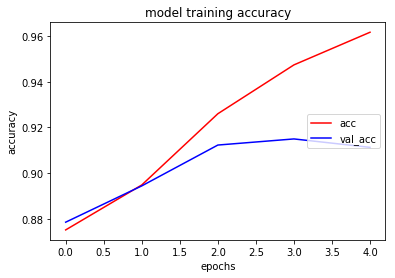

In [6]:
# load history dict from training
hist_dict = np.load('model/lstm_hist_dict.npy').item()
plt.plot(hist_dict['acc'], 'red', label='acc')
plt.plot(hist_dict['val_acc'], 'blue', label='val_acc')
plt.title("model training accuracy")
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc=7)
plt.show()

In [7]:
decoded = []

all_label = []
all_trues = []

false_pos = 0
false_neg = 0
true_pos = 0


def gettag(val):
    label = 'ERR'
    if val < 0.5:
        label = 'NON'
    else:
        label = 'MET'
    return(label)

for sent_idx in range(len(X_test[:500])):
    
    this_txt = sequence.pad_sequences([X_test[sent_idx]], maxlen=MAX_LENGTH, truncating='post', padding='post')
    this_pred = model.predict([this_txt])
    this_pred = [np.argmax(p) for p in this_pred[0]]

    word, tru, prd = [], [], []

    # for each word in the sentence...
    for idx, wordid in enumerate(X_test[sent_idx][:MAX_LENGTH]):
        
        # break if hit padding (end of sentence)
        if wordid == 0:
            break

        # decode word
        word.append(idx2word[wordid])
        # decode true NER tag
        tru.append(y_test[sent_idx][idx])
        # decode prediction
        prd.append(this_pred[idx])
        
        if y_test[sent_idx][idx] == 1 and this_pred[idx] == 1:
            true_pos += 1
        elif y_test[sent_idx][idx] == 1 and this_pred[idx] == 0:
            false_neg += 1
        elif y_test[sent_idx][idx] == 0 and this_pred[idx] == 1:
            false_pos += 1
            
        all_label.append(this_pred[idx])
        all_trues.append(y_test[sent_idx][idx])

    answ = pd.DataFrame(
    {
        'word': word,
        'true': tru,
        'pred': prd,
        'skip' : [' ' for s in word]
    })
    answ = answ[['word', 'true', 'pred', 'skip']]
    answ = answ.T
    decoded.append(answ)

In [8]:
print(classification_report(all_trues, all_label))

             precision    recall  f1-score   support

        0.0       0.88      1.00      0.94      4968
        1.0       0.00      0.00      0.00       662

avg / total       0.78      0.88      0.83      5630



/home/derek/keras-contrib/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
result = pd.concat(decoded)

In [10]:
result

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
word,candid,camera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
true,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pred,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
skip,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
word,we,can,now,make,the,link,between,this,model,of,...,in,schools,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
true,0,0,0,1,0,1,1,1,1,0,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pred,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
skip,,,,,,,,,,,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
word,as,at,all,his,power,stations,scott,faced,the,building,...,that,has,weathered,to,a,lovely,pinky-brown,NaN,NaN,NaN
true,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,NaN,NaN,NaN


In [11]:
result.to_csv('sample_results_lstm.csv')

## LSTM-CRF model

In [12]:
print('Building model...\n')
# params
MAX_LENGTH = 25
MAX_VOCAB = 18000    # see preprocessing.ipynb
EMBEDDING_SIZE = 128 # from default gensim model, see preprocessing.ipynb
HIDDEN_SIZE = 256       # LSTM Nodes/Features/Dimension
BATCH_SIZE = 128
DROPOUTRATE = 0.0

# text layers : dense embedding > dropout > bi-LSTM
txt_input = Input(shape=(MAX_LENGTH,), name='txt_input')
txt_embed = Embedding(MAX_VOCAB, EMBEDDING_SIZE, input_length=MAX_LENGTH,
                      mask_zero=True,
                      name='txt_embedding', trainable=True)(txt_input)
txt_drpot = Dropout(DROPOUTRATE, name='txt_dropout')(txt_embed)
txt_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='txt_bidirectional_1')(txt_drpot)
txt_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='txt_bidirectional_2')(txt_lstml)
txt_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='txt_bidirectional_3')(txt_lstml)

# final linear chain CRF layer
crf = CRF(2, sparse_target=True)
mrg_chain = crf(txt_lstml)

model = Model(inputs=[txt_input], outputs=mrg_chain)

Building model...



In [13]:
# load model
save_load_utils.load_all_weights(model,'model/crf_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
txt_input (InputLayer)       (None, 25)                0         
_________________________________________________________________
txt_embedding (Embedding)    (None, 25, 128)           2304000   
_________________________________________________________________
txt_dropout (Dropout)        (None, 25, 128)           0         
_________________________________________________________________
txt_bidirectional_1 (Bidirec (None, 25, 512)           788480    
_________________________________________________________________
txt_bidirectional_2 (Bidirec (None, 25, 512)           1574912   
_________________________________________________________________
txt_bidirectional_3 (Bidirec (None, 25, 512)           1574912   
_________________________________________________________________
crf_2 (CRF)                  (None, 25, 2)             1034      
Total para

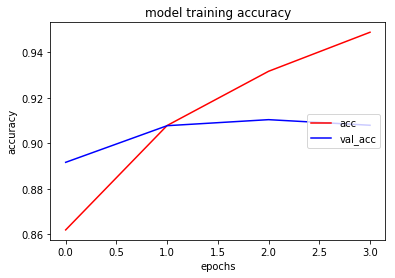

In [14]:
# load history dict from training
hist_dict = np.load('model/crf_hist_dict.npy').item()
plt.plot(hist_dict['acc'], 'red', label='acc')
plt.plot(hist_dict['val_acc'], 'blue', label='val_acc')
plt.title("model training accuracy")
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc=7)
plt.show()

In [15]:
decoded = []

all_label = []
all_trues = []

false_pos = 0
false_neg = 0
true_pos = 0


def gettag(val):
    label = 'ERR'
    if val < 0.5:
        label = 'NON'
    else:
        label = 'MET'
    return(label)

for sent_idx in range(len(X_test[:500])):
    
    this_txt = sequence.pad_sequences([X_test[sent_idx]], maxlen=MAX_LENGTH, truncating='post', padding='post')
    this_pred = model.predict([this_txt])
    this_pred = [np.argmax(p) for p in this_pred[0]]

    word, tru, prd = [], [], []

    # for each word in the sentence...
    for idx, wordid in enumerate(X_test[sent_idx][:MAX_LENGTH]):
        
        # break if hit padding (end of sentence)
        if wordid == 0:
            break

        # decode word
        word.append(idx2word[wordid])
        # decode true NER tag
        tru.append(y_test[sent_idx][idx])
        # decode prediction
        prd.append(this_pred[idx])
        
        if y_test[sent_idx][idx] == 1 and this_pred[idx] == 1:
            true_pos += 1
        elif y_test[sent_idx][idx] == 1 and this_pred[idx] == 0:
            false_neg += 1
        elif y_test[sent_idx][idx] == 0 and this_pred[idx] == 1:
            false_pos += 1
            
        all_label.append(this_pred[idx])
        all_trues.append(y_test[sent_idx][idx])

    answ = pd.DataFrame(
    {
        'word': word,
        'true': tru,
        'pred': prd,
        'skip' : [' ' for s in word]
    })
    answ = answ[['word', 'true', 'pred', 'skip']]
    answ = answ.T
    decoded.append(answ)

In [16]:
print(classification_report(all_trues, all_label))

             precision    recall  f1-score   support

        0.0       0.94      0.95      0.95      4968
        1.0       0.63      0.58      0.60       662

avg / total       0.91      0.91      0.91      5630



In [17]:
print("metaphor-positive label info")
print("true positives :", true_pos)
print("false positives:", false_pos)
print("false negatives:", false_neg)
print("rcll (tp/tp+fn):", true_pos*100/(true_pos+false_neg))
print("prec (tp/tp+fp):", true_pos*100/(true_pos+false_pos))

metaphor-positive label info
true positives : 384
false positives: 229
false negatives: 278
rcll (tp/tp+fn): 58.00604229607251
prec (tp/tp+fp): 62.64274061990212


In [18]:
result = pd.concat(decoded)

In [19]:
result

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
word,candid,camera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
true,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pred,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
skip,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
word,we,can,now,make,the,link,between,this,model,of,...,in,schools,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
true,0,0,0,1,0,1,1,1,1,0,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pred,0,0,0,1,0,1,1,1,1,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
skip,,,,,,,,,,,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
word,as,at,all,his,power,stations,scott,faced,the,building,...,that,has,weathered,to,a,lovely,pinky-brown,NaN,NaN,NaN
true,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,NaN,NaN,NaN


In [20]:
result.to_csv('sample_results_crf.csv')